<a href="https://colab.research.google.com/github/andreytsimbalov/Diplom/blob/main/Parser_news_RIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Парсер с Риа новости https://ria.ru/search/

In [ ]:
import requests
import threading
from bs4 import BeautifulSoup
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import time
import random

%matplotlib inline
import matplotlib.pyplot as plt

url = 'https://newssearch.yandex.ru/yandsearch?rpt=nnews2&rel=rel&within=9'
HEADER = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36', 
          'accept': '*/*'}
r = requests.get(url, headers = HEADER)
soup = BeautifulSoup(r.content.decode('utf-8','ignore'), 'html.parser')
news = []
for link in soup.find_all('li', class_ =  'search-item'):
    news+=[link.text]
news

for i in tqdm(range(100)):
    r = requests.get(url, headers = HEADER)
    soup = BeautifulSoup(r.content.decode('utf-8','ignore'), 'html.parser')
    if len(soup.find_all('li', class_ =  'search-item')):
        print(123)    
soup

In [ ]:
url = 'https://ria.ru/search/'
# url = 'https://ria.ru/services/search/getmore/?query=&amp;offset=20&amp;interval=week'

HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36', 
          'accept': '*/*'}

# /services/search/getmore/?query=&offset=20&interval=period&date_from=2020-12-18&date_to=2020-12-25

PARAMS = {'interval': "period",
          'date_from':'2020-08-31',
          'date_to':'2020-08-31',
          'offset': 0}
          
r = requests.get(url,params = PARAMS)
soup = BeautifulSoup(r.text, 'html.parser')

len_news = int(soup.find_all('div', class_ =  'rubric-count m-active')[0].text.split(' ')[0])
len_news

811

In [ ]:
item = soup.find_all('div', class_ =  'list-item')[0]
item.text

'Экипаж МКС сузил зону поиска утечки воздуха 30 сентября 2020, 23:505738'

In [ ]:
def take_ria_news(url_one):
    r=requests.get(url_one).text
    bs = BeautifulSoup(r, 'html.parser')

    tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 

    texts = bs.find_all('div', class_ = 'article__block')
    main_text = ''
    for _ in texts:
        t = _.find('div',class_ ="article__quote")
        if not t is None:
            main_text += t.text+' '

        t = _.find('div',class_ ="article__text")
        if not t is None:
            main_text += t.text+' '

    return tags, main_text

# take_ria_news(news_ria['link'])

In [ ]:
def take_news(link): # просматривает новость на ria search

    new_item = {}
    new_item['date'] = link.find('div', class_="list-item__date").text.split(', ')[0]
    new_item['time'] = link.find('div', class_="list-item__date").text.split(', ')[1]
    new_item['views'] = int(link.find('div', class_='list-item__views-text').text)
    
    new_item['headline'] = link.find('span',class_="share").get('data-title')
    new_item['link']= link.find('a').get('href')
    new_item['tags'] = []
    new_item['text'] = ''


#     flag = new_item['link'].find('https://ria.ru')!=-1 or new_item['link'].find('https://rsport.ria.ru')!=-1
    flag = new_item['link'].find('ria.ru')!=-1
    
    if (flag):
        try_to_get_tags_and_text = True
        try_counter = 0

        while try_to_get_tags_and_text: 
          try_counter+=1

          # if try_counter%10==0:
          #   print(f't&t pars processing - {try_counter} try')


          if try_counter>20:
            print("dont getted tags and text "+ str(new_item['link']))
            try_to_get_tags_and_text = False
            continue

          try:
            new_item['tags'], new_item['text'] = take_ria_news(new_item['link']) #, new_item['text']
          except:
            print("smth is wrong with t&t")
          if new_item['text']=='':
            time.sleep(random.uniform(0.01,0.1)+ try_counter//10)
            time.sleep(0)
          else:
            try_to_get_tags_and_text = False
            # if try_counter>1:
            #   print(f'success t&t pars with {try_counter} try')
              
    else:
      print("we have not news_text on link "+str(link))
    return new_item
    
# take_news(item)



**Сбор новостей**

In [ ]:
MIN_VIEWS_ON_NEWS = 10000 #отсев новостей с менее 10к просмотров

({'date_from': '2020-08-1',
  'date_to': '2020-08-30',
  'interval': 'period',
  'offset': 123},
 {'date_from': '2020-08-1',
  'date_to': '2020-08-30',
  'interval': 'period',
  'offset': 0})

In [ ]:
lock = threading.Lock()

def take_1_news(news_item):

  # print(f'ones started')
  views_on_news = int(news_item.find('div', class_='list-item__views-text').text)

  flag = news_item.find('a').get('href').find('radiosputnik.ria.ru')==-1 and \
      views_on_news>MIN_VIEWS_ON_NEWS 

  # flag=True # потом не забыть урбрать

  if flag: 
      news_one = take_news(news_item)
      global news
      with lock:
        news.extend([news_one])
  #     print(f'ones finished_ {views_on_news}')
  # else:
  #     print(f'ones cant finished_ {views_on_news} _!')


def take_20_news(i, par):
  # try:
  # print(f'{i} started')
  one_news_of_time = time.time()

  offset = i*20
  params = par.copy()
  params['offset'] = offset

  # print(f'{i} {params}')

  success_try_to_parsing = True
  try_counter=0

  while success_try_to_parsing:
    try_counter+=1
    r = requests.get(url,params = params)
    soup = BeautifulSoup(r.text, 'html.parser')
    # print(f'{i} {params}')

    thrs = [threading.Thread(target=take_1_news, args= (news_item,)) 
            for news_item in soup.find_all('div', class_ =  'list-item')]
    

    # print(f'{i}-{len(thrs)}-{ln} ')
    if len(thrs)<20:
      if try_counter>30:
        print(f'ERROR__ {i} {params}')
        return

      time.sleep(random.uniform(0.01, 0.1)+try_counter//20)
      continue
    else:
      # print(f'SUCCESS__ {i} with {try_counter} try')
      success_try_to_parsing = False

    for th in thrs:
      # time.sleep(2)
      th.start()

    
    for th in thrs:
      th.join()

    # for news_item in soup.find_all('div', class_ =  'list-item'):
    #     take_1_news(news_item)

    
    time_delay = time.time()-one_news_of_time

    global max_time_delay
    with lock:
      max_time_delay = max(max_time_delay, time_delay)
  
  print(f'{i} finished {len(news)} ({i*20/len_news})')
  # except:
  #   print('error',i)

In [ ]:
news = []
max_time_delay=0
max_thread_number = 10
threads_index = set([])


arr_news_of_time = time.time()
# for i in tqdm(range(len_news//20)):#len_news//20
# for i in tqdm(range(0,10)):#len_news//20

# thrs_main = [threading.Thread(target=take_20_news, args= (i,PARAMS,)) 
#               for i in range(0,50)]

thrs_main = [threading.Thread(target=take_20_news, args= (i,PARAMS,)) 
              for i in range(len_news//20)]

now_threads = set([])

iterator = 0

while iterator<len(thrs_main):
  finished_threads=set([])
  for th in now_threads:
    if not th.isAlive():
      finished_threads.add(th)
  now_threads-=finished_threads
  
  while len(now_threads)<max_thread_number:
    now_threads.add(thrs_main[iterator])
    thrs_main[iterator].start()
    iterator+=1
    time.sleep(0.1)
  
  time.sleep(0)


# for ths in thrs_main:
#   time.sleep(0.1)
#   ths.start()

for ths in thrs_main:
  ths.join()

print(time.time()-arr_news_of_time)
print(f'max_time_delay {max_time_delay}')
len(news)

3 finished 7 (0.07398273736128237)
7 finished 17 (0.17262638717632553)
8 finished 20 (0.19728729963008632)
6 finished 22 (0.14796547472256474)
9 finished 23 (0.2219482120838471)
0 finished 28 (0.0)
4 finished 30 (0.09864364981504316)
13 finished 32 (0.3205918618988903)
12 finished 35 (0.2959309494451295)
14 finished 36 (0.34525277435265106)
1 finished 38 (0.02466091245376079)
2 finished 40 (0.04932182490752158)
17 finished 43 (0.4192355117139334)
16 finished 48 (0.39457459926017263)
10 finished 49 (0.2466091245376079)
21 finished 51 (0.5178791615289766)
5 finished 53 (0.12330456226880394)
15 finished 54 (0.36991368680641185)
20 finished 55 (0.4932182490752158)
22 finished 58 (0.5425400739827374)
11 finished 59 (0.2712700369913687)
19 finished 65 (0.468557336621455)
27 finished 68 (0.6658446362515413)
29 finished 69 (0.7151664611590629)
23 finished 70 (0.5672009864364982)
28 finished 71 (0.6905055487053021)
24 finished 74 (0.591861898890259)
26 finished 76 (0.6411837237977805)
31 finish

119

In [ ]:
news = []

max_time_delay=0

# for i in tqdm(range(len_news//20)):#len_news//20
for i in tqdm(range(0,50)):#len_news//20
    # try:
    one_news_of_time = time.time()

    offset = i*20
    PARAMS['offset'] = offset
    r = requests.get(url,params = PARAMS)
    soup = BeautifulSoup(r.text, 'html.parser')

    thrs = [threading.Thread(target=take_1_news, args= (news_item,)) 
            for news_item in soup.find_all('div', class_ =  'list-item')]
    
    print(len(thrs))
    # print(f'init_thrs {time.time()-one_news_of_time}')

    for th in thrs:
      th.start()

    # print(f'start_thrs {time.time()-one_news_of_time}')
    
    for th in thrs:
      th.join()
    # print(f'fin_thrs {time.time()-one_news_of_time}')

    # for news_item in soup.find_all('div', class_ =  'list-item'):
    #     take_1_news(news_item)

    
    time_delay = time.time()-one_news_of_time

    print(f'{time_delay} {len(news)}')

    max_time_delay = max(max_time_delay, time_delay)
    # except:
    #     print(f'eRRor {i}')


print(f'max_time_delay {max_time_delay}')
len(news)

20
2.5469040870666504 3
20
3.1243913173675537 7
20
2.4239554405212402 11
20
2.1410157680511475 13
20
2.0580928325653076 14
20
4.113449335098267 18
20
2.8843438625335693 20
20
2.350877046585083 22
20
2.077316999435425 24
20
1.9520072937011719 25
20
dont getted tags and text https://ria.ru/20200930/kak-v-rossii-budet-vystroena-sistema-retsiklinga-1577991695.html
33.67931866645813 29
20
2.181375741958618 31
20
2.868912696838379 33
20
3.3993425369262695 37
20
2.7602880001068115 40
20
2.547605514526367 44
20
3.2694365978240967 46
20
3.2842414379119873 47
20
2.110531806945801 49
20
2.7873666286468506 52
20
2.7124781608581543 54
20
2.421464443206787 55
20
3.2465851306915283 56
20
3.1883528232574463 59
20
1.9803121089935303 59
20
2.555732488632202 64
1
5.721160650253296 64


Exception in thread Thread-3891:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-26-87e2e81fad2c>", line 6, in take_1_news
    views_on_news = int(news_item.find('div', class_='list-item__views-text').text)
AttributeError: 'NoneType' object has no attribute 'text'



20
3.0137953758239746 68
20
2.9239726066589355 71
20
2.8506553173065186 72
20
dont getted tags and text https://realty.ria.ru/20200930/srv-1577753451.html
36.73002219200134 76
20
4.807019472122192 78
20
2.9339051246643066 83
20
2.544027090072632 84
20
2.8476319313049316 86
20
2.0926225185394287 88
20
2.5908396244049072 91
20
3.081753969192505 94
20
2.25645112991333 96
20
2.6133320331573486 98
20
3.198267698287964 100
20
4.724199295043945 108
1
5.848837852478027 108


Exception in thread Thread-4192:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-26-87e2e81fad2c>", line 6, in take_1_news
    views_on_news = int(news_item.find('div', class_='list-item__views-text').text)
AttributeError: 'NoneType' object has no attribute 'text'



20
4.880273342132568 115
20
4.774727821350098 121
20
3.4834983348846436 124
20
2.4209678173065186 127
20
5.35072135925293 129
20
3.022469997406006 132
20
2.6056864261627197 133

max_time_delay 36.73002219200134


133

In [ ]:
[n['text']  for n in news][:10]

['ЕКАТЕРИНБУРГ, 31 янв - РИА Новости. Состояние китайской студентки, больной коронавирусом в Тюменской области, удовлетворительное, заболевание протекает в легкой форме, сообщает управление Роспотребнадзора по региону. В пятницу вице-премьер РФ Татьяна Голикова заявила, что в РФ выявлены два первых случая коронавируса, в Забайкальском крае и Тюменской области, оба заболевших - граждане Китая. Губернатор Тюменской области Александр Моор сообщил, что в регионе лабораторно подтвержден случай коронавируса у китайской студентки. "Больная с первого дня пребывания в Тюмени находится в боксированном отделении инфекционного стационара, лица из близкого контакта также госпитализированы. Все остальные возможные контактные лица находятся под медицинским наблюдением. Заболевание протекают в легкой клинической форме, на 31 января 2020 года состояние удовлетворительное, жалоб нет", - говорится в сообщении. Организован полный комплекс противоэпидемических мер, направленный на недопущение распространен

In [ ]:
news[0]

{'date': '30 августа 2020',
 'headline': 'Правление Джукановича закончилось, заявил один из лидеров оппозиции',
 'link': 'https://ria.ru/20200830/dzhukanovich-1576502262.html',
 'tags': [],
 'text': '',
 'time': '23:00',
 'views': 4870}

In [ ]:
news[0]

{'date': '30 августа 2020',
 'headline': 'В Москве избили блогера Егора Жукова',
 'link': 'https://ria.ru/20200830/zhukov-1576502042.html',
 'tags': [],
 'text': '',
 'time': '22:44',
 'views': 62306}

**Тесты**

In [ ]:
def take_sport_news(url_one):
    bs = BeautifulSoup(requests.get(url_one).text, 'html.parser')
    tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 
    
    texts = bs.find_all('div', class_ = 'article__block')
    main_text = ''
    for _ in texts:
        t = _.find('div',class_ ="article__quote")
        if not t is None:
            main_text += t.text

        t = _.find('div',class_ ="article__text")
        if not t is None:
            main_text += t.text

    return tags, main_text

take_ria_news(news_sport['link'])

(['Локомотив (Москва)', 'Юрий Семин', 'Футбол'],
 'МОСКВА, 31 дек - РИА Новости. Бывший главный тренер московского "Локомотива" Юрий Семин выразил надежду, что для болельщиков футбольного клуба сложное время осталось в уходящем году.В декабре генеральный директор "Локомотива" Василий Кикнадзе и глава совета директоров столичного клуба Анатолий Мещеряков покинули свои посты. Их заменили Владимир Леонченко и Александр Плутник соответственно."Конечно, особые пожелания болельщикам "Локомотива". Очень надеюсь, что для вас сложное время осталось в 2020 году. Дай бог вам много побед и положительных эмоций", - написал Семин на своей странице в Instagram.В мае совет директоров "Локомотива" решил не продлевать контракт с Семиным, который возглавлял команду с 2016 года. Новым главным тренером железнодорожников стал сербский специалист Марко Николич. "Локомотив" после 19 туров занимает восьмое место в чемпионате России, на 13 очков отставая от лидирующего санкт-петербургского "Зенита".')

In [ ]:
url_one = news_sport['link']
bs = BeautifulSoup(requests.get(url_one).text, 'html.parser')

In [ ]:
news_sport['link'].find('https://rsport.ria.ru')

0

In [ ]:
news_sport

{'date': '31 декабря 2020',
 'time': '21:41',
 'views': 409,
 'headline': 'Семин надеется, что сложное время для фанатов "Локо" осталось в 2020 году',
 'link': 'https://rsport.ria.ru/20201231/semin-1591737868.html',
 'tags': [],
 'text': ''}

In [ ]:
tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 
len(tags)

3

In [ ]:
tags

['Локомотив (Москва)', 'Юрий Семин', 'Футбол']

In [ ]:
texts = bs.find_all('div', class_ = 'article__block')
len(texts)

6

In [ ]:
main_text = ''
for _ in texts:
    t = _.find('div',class_ ="article__quote")
    if not t is None:
        main_text += t.text
        
    t = _.find('div',class_ ="article__text")
    if not t is None:
        main_text += t.text
        
main_text

'БАКУ, 31 дек – РИА Новости. Президент Азербайджана Ильхам Алиев заявил в новогоднем обращении, что ЮНЕСКО ложно обвиняет Баку в связи ситуацией с армянскими памятниками в Нагорном Карабахе.Гендиректор ЮНЕСКО по вопросам культуры Эрнесто Оттоне заявил 21 декабря, что организация ожидает ответа от Азербайджана по поводу возможности отправления экспертной миссии организации в Карабах. Он отметил, что к властям Азербайджана неоднократно обращались по этому вопросу, но безуспешно."Мы довели до мировой общественности правду о войне, о разрушенных городах, селах, в то время как у нас не было возможности ездить в эти села, города. Ни одна международная организация не посещала их, ЮНЕСКО, которая сегодня пытается предъявлять нам претензии в том, что мы якобы не сможем защитить здесь армянские религиозные памятники. Хотя это ложь. В Азербайджане охраняются памятники всех религий", - сказал Алиев."Хоть раз она побывала на этих землях? Хоть раз побывала в Шушинской мечети? Побывала в разрушенной 

In [ ]:
texts[0]

<div class="article__block" data-type="text"><div class="article__text"><strong>БАКУ, 31 дек – РИА Новости.</strong> Президент Азербайджана <a data-auto="true" href="http://ria.ru/person_Ilkham_Aliev/" target="_blank">Ильхам Алиев</a> заявил в новогоднем обращении, что <a data-auto="true" href="http://ria.ru/organization_JUNESKO/" target="_blank">ЮНЕСКО</a> ложно обвиняет Баку в связи ситуацией с армянскими памятниками в Нагорном Карабахе.</div></div>

In [ ]:
a = texts[3].find('div',class_ ="article__quote")
a.text

'"Мы довели до мировой общественности правду о войне, о разрушенных городах, селах, в то время как у нас не было возможности ездить в эти села, города. Ни одна международная организация не посещала их, ЮНЕСКО, которая сегодня пытается предъявлять нам претензии в том, что мы якобы не сможем защитить здесь армянские религиозные памятники. Хотя это ложь. В Азербайджане охраняются памятники всех религий", - сказал Алиев.'

In [ ]:
item.find('span').get('data-title')

In [ ]:
item.find('span',class_="share").get('data-title')

'Упала на плечо Тутберидзе: Щербакова лидирует после короткой программы '

In [ ]:
item.find('div', class_="list-item__date").text

'25 декабря, 23:50'

In [ ]:
item.find('div', class_='list-item__views-text').text

'15988'

**конец тестам**

# Графики просмотров - views

In [ ]:
views = np.array([])
for n in news:
    views = np.append(views,n['views'])
views = views.astype(int)
views[:10]

array([ 16245,  15929,  55210,  16355, 285768,  43822,  16526,  13995,
        10003,  43116])

In [ ]:
views.sort()
views[-100:]

array([ 395547,  404601,  405084,  406745,  413018,  413501,  414089,
        414728,  419381,  419744,  420034,  420399,  422445,  431220,
        431420,  431737,  435331,  437170,  445700,  449650,  449968,
        450315,  454142,  459350,  462405,  463800,  471581,  472916,
        473567,  476710,  484385,  488490,  492820,  496354,  498120,
        500107,  507206,  508269,  509731,  526336,  526392,  528996,
        530300,  537679,  540233,  542611,  543071,  544825,  555778,
        562478,  577044,  579691,  581330,  583840,  599521,  606509,
        610880,  615389,  628000,  644936,  657877,  658076,  658372,
        658395,  675735,  687723,  695289,  706485,  717585,  732812,
        736559,  752911,  754050,  791119,  796262,  801801,  816570,
        827783,  852171,  863976,  894137,  898218,  904152,  918090,
        940725,  942387,  947538,  951578,  971487,  975277, 1014105,
       1109572, 1137120, 1180373, 1269338, 1534793, 1561369, 1698516,
       1718847, 1773

In [ ]:
len(views[views>1100000])

9

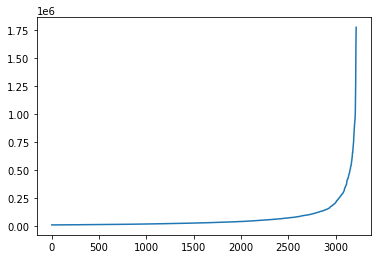

In [ ]:
plt.plot(views)
plt.show()

In [ ]:
num_views_hist = 100
views_hist = np.histogram(views, bins = np.linspace(views.min(),views.max(), num_views_hist))
views_hist = views_hist[0].astype(np.int64)
views_hist

array([1805,  625,  355,  240,  168,  134,   93,   90,   59,   40,   40,
         38,   34,   30,   18,   21,   14,   17,   14,    5,   13,    8,
          6,    6,    3,    7,    6,    4,    4,    5,    2,    7,    7,
          5,    3,    8,    3,    5,    6,    4,    2,    3,    4,    4,
          1,    1,    1,    4,    2,    1,    2,    0,    1,    2,    3,
          0,    0,    1,    1,    2,    0,    2,    1,    0,    0,    0,
          0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    1,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2])

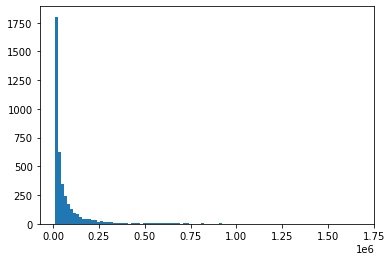

In [ ]:
plt.hist(views, bins = num_views_hist)#np.linspace(0,len(views), 7)
plt.show()

# Создание датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

Mounted at /content/drive


In [ ]:
# counter = 0
# for i in news:
#     if i['link'].find('sport.ria.ru')!=-1:
#         counter+=1
# counter

In [ ]:
data = pd.DataFrame(news)
data.head()

,date,time,views,headline,link,tags,text
0,31 августа 2020,23:14,14849,Удары по пригороду Дамаска нанесли ВВС Израиля...,https://ria.ru/20200831/siriya-1576553484.html,"[Война в Сирии, Война в Сирии, ВВС Израиля, Да...","БЕЙРУТ, 31 авг - РИА Новости. Сирийское госуда..."
1,31 августа 2020,23:19,17760,Huawei предсказали смерть на рынке смартфонов,https://ria.ru/20200831/huawei-1576553572.html,"[Xiaomi Inc, Huawei Technologies, Apple, Китай...","МОСКВА, 31 авг — РИА Новости. Корпорация Huawe..."
2,31 августа 2020,23:12,33024,"Потерпевшие хотят наказать ""опознавших"" Ефремо...",https://ria.ru/20200831/svideteli-1576553446.html,"[Эльман Пашаев, ДТП с участием Михаила Ефремов...","МОСКВА, 31 авг — РИА Новости. Адвокаты потерпе..."
3,31 августа 2020,21:06,21322,Попова оценила возможность второй волны корона...,https://ria.ru/20200831/covid-19-1576551388.html,"[Распространение коронавируса, Коронавирус в Р...","МОСКВА, 31 авг – РИА Новости. Глава Роспотребн..."
4,31 августа 2020,19:55,10974,ВОЗ поддержала открытие международных границ,https://ria.ru/20200831/voz-1576549179.html,"[Распространение коронавируса, Коронавирус в Р...","ЖЕНЕВА, 31 авг – РИА Новости, Елизавета Исаков..."


In [ ]:
len(data)

119

In [ ]:
 data_1 = pd.read_pickle(md+'data/news_08_2020')
 data_1

,date,time,views,headline,link,tags,text
0,30 августа 2020,22:50,123030,Пьяный Депардье заявил французским полицейским...,https://ria.ru/20200830/deparde-1576502173.html,"[Жерар Депардье, Владимир Путин, Париж, В мире]","МОСКВА, 30 авг — РИА Новости. Полиция Парижа о..."
1,30 августа 2020,22:46,10922,"Оппозиция объявила о ""падении режима"" по итога...",https://ria.ru/20200830/krivokapich-1576502143...,"[Парламентские выборы в Черногории, Черногория...","ПОДГОРИЦА, 30 авг — РИА Новости. Правление в Ч..."
2,30 августа 2020,22:44,62302,В Москве избили блогера Егора Жукова,https://ria.ru/20200830/zhukov-1576502042.html,"[Дело Егора Жукова, Егор Жуков, Федеральная сл...","МОСКВА, 30 авг - РИА Новости. Осужденный за пр..."
3,30 августа 2020,22:31,691515,Уснувшей женщине заползла в рот огромная змея,https://ria.ru/20200830/zmeya-1576501797.html,"[Республика Дагестан, Общество - Видео, Происш...","МОСКВА, 30 авг — РИА Новости. В рот к уснувшей..."
4,30 августа 2020,22:24,12404,Экзитпол: на выборах в парламент Черногории ли...,https://ria.ru/20200830/ekzitpol-1576501653.html,"[Парламентские выборы в Черногории, Черногория...","ПОДГОРИЦА, 30 авг – РИА Новости. На выборах в ..."
...,...,...,...,...,...,...,...
3356,1 августа 2020,03:31,10405,"Эксперт рассказал, сколько будет стоить новый ...",https://ria.ru/20200801/1575245349.html,"[Денис Кусков, Apple iPhone, Технологии, Эконо...","МОСКВА, 1 авг — РИА Новости. В Сети появляется..."
3357,1 августа 2020,02:57,103751,Друг рэпера Энди Картрайта рассказал о странно...,https://ria.ru/20200801/1575245558.html,"[Марина Кохал, Гибель украинского рэпера в Пет...","МОСКВА, 1 авг — РИА Новости. Друг погибшего в ..."
3358,1 августа 2020,02:34,99748,Синоптик предупредил москвичей о надвигающейся...,https://ria.ru/20200801/1575245402.html,"[Анатолий Цыганков, Россия, Погода, Федеральна...","МОСКВА, 1 авг — РИА Новости. На Москву надвига..."
3359,1 августа 2020,02:03,53196,"""Это недопустимо"": Малышева рассказала, кому н...",https://ria.ru/20200801/1575245190.html,"[Распространение коронавируса, Медицинские мас...","МОСКВА, 1 авг — РИА Новости. Детям нельзя носи..."


In [ ]:
data.index = np.arange(len(data))

In [ ]:
# data.to_csv(md+"data/news_10_2020.csv", index = False)
data.to_pickle(md+"data/news_08_2020")

In [ ]:
# data = pd.read_csv("last_week.csv")
data = pd.read_pickle(md+"data/january_month")
data.head()

,date,time,views,headline,link,tags,text
0,31 декабря 2020,23:55,13334,Алиев ответил на обвинения ЮНЕСКО из-за армянс...,https://ria.ru/20201231/pamyatniki-1591740604....,"[Ситуация в Нагорном Карабахе, Никол Пашинян, ...","БАКУ, 31 дек – РИА Новости. Президент Азербайд..."
1,31 декабря 2020,23:19,40433,ВОЗ внесла вакцину Pfizer в список для экстрен...,https://ria.ru/20201231/vaktsina-1591739960.html,"[Распространение коронавируса, Панамериканская...","МОСКВА, 31 дек - РИА Новости. Всемирная органи..."
2,31 декабря 2020,21:42,42263,В Сургуте Дед Мороз разбился в ДТП,https://ria.ru/20201231/dtp-1591738065.html,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...","МОСКВА, 31 дек — РИА Новости. Мужчина в костюм..."
3,31 декабря 2020,21:16,29885,В Москве задержали или отменили около 105 рейсов,https://ria.ru/20201231/reys-1591737184.html,"[Домодедово (аэропорт), Шереметьево (аэропорт)...","МОСКВА, 31 дек — РИА Новости. В московских аэр..."
4,31 декабря 2020,20:07,455876,Депутат Рады надел шапку с красной звездой и о...,https://ria.ru/20201231/shapka-1591735431.html,"[Оппозиционная платформа - За жизнь, Ситуация ...","МОСКВА, 31 дек — РИА Новости. Депутат Рады от ..."


In [ ]:
data.tags[0]

['Ситуация в Нагорном Карабахе',
 'Никол Пашинян',
 'ЮНЕСКО',
 'Ильхам Алиев',
 'Москва',
 'Азербайджан',
 'Армения',
 'В мире']

# Тесты

In [ ]:
import numpy as np
n=1000000

%timeit

a=np.array(range(n))
b=np.array(range(0,n*2,2))

def sum_c():
  c = np.zeros(n)
  for i in range(n):
      c[i] = a[i] + b[i]
  return c
sum_c()

array([0.000000e+00, 3.000000e+00, 6.000000e+00, ..., 2.999991e+06,
       2.999994e+06, 2.999997e+06])

In [ ]:
!pip install numba

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
from numba import cuda # Библиотека Nvidia для работы с GPU 
import numpy as np 

@cuda.jit('void(float32[:], float32[:], float32[:])') #Динамический компилятор Cuda 
def cuda_addition(a,b,c):
    """Поток будет выполнять эту функцию ядра."""
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    if i > c.size:
        return
    c[i] = a[i]+b[i] #Perform the addition
 
# Подробности об устройстве
device = cuda.get_current_device()

device

In [ ]:
# Перенос с хоста на устройство
d_a = cuda.to_device(a)  # Перенос данных в глобальную память GPU
d_b = cuda.to_device(b)  # Перенос данных в глобальную память GPU
d_c = cuda.device_array_like(a)

tpb = device.WARP_SIZE       #blocksize или количество потоков на блок, стандартное значение = 32
bpg = int(np.ceil((n)/tpb))  # блоков на грид

cuda_addition[bpg, tpb](d_a, d_b, d_c) # вызов ядра

# Перенос вывода с устройства на хост
c = d_c.copy_to_host()
print(c)

In [ ]:
import threading
import time

flag1=False
flag2=False

def print_time( threadName, delay):
   count = 0
   while count < 5:
      time.sleep(delay)
      count += 1
      print ("%s: %s: %s" % ( count, threadName, time.ctime(time.time()) ))
   

not_started_threads = time.time()

t1=threading.Thread(target=print_time, args= ("Thread-1", 0.1,) )
t2=threading.Thread(target= print_time, args=("Thread-2", 0.2,) )

t1.start()
t2.start()

print(t1,t2)


t1.join()
t2.join()

print(time.time() - not_started_threads)

<Thread(Thread-11, started 140177633539840)> <Thread(Thread-12, started 140177616754432)>
1: Thread-1: Mon Feb  8 16:43:52 2021
1: Thread-2: Mon Feb  8 16:43:52 2021
2: Thread-1: Mon Feb  8 16:43:52 2021
3: Thread-1: Mon Feb  8 16:43:52 2021
2: Thread-2: Mon Feb  8 16:43:52 2021
4: Thread-1: Mon Feb  8 16:43:52 2021
5: Thread-1: Mon Feb  8 16:43:52 2021
3: Thread-2: Mon Feb  8 16:43:52 2021
4: Thread-2: Mon Feb  8 16:43:52 2021
5: Thread-2: Mon Feb  8 16:43:52 2021
1.0066328048706055


In [ ]:
def fl( flag):
  global flag.name()
  flag=not flag
  print(flag)

print(flag1)
fl(flag1)
print(flag1)

SyntaxError: ignored

In [ ]:
global w
    print(w)
    w = 20